# Preprocessing and get data 

Install and import packages



In [0]:
!pip install firebase_admin

In [0]:
!pip install firebase

In [0]:
!pip install networkx

In [0]:
import numpy as np
import pandas as pd
from google.colab import drive

In [0]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/Colab Notebooks"

 AnalyzeDataPython.ipynb				      Untitled0.ipynb
 code-names-project-firebase-adminsdk-bgnn1-bc2e2f3e6e.json   Untitled1.ipynb
 code_names_words.txt					      Untitled2.ipynb
'Copy of AnalyzeDataPython.ipynb'			      Untitled3.ipynb


In [0]:
import firebase_admin
from firebase_admin import credentials, firestore

Get data from firebase

In [0]:

cred = credentials.Certificate('/content/drive/My Drive/Colab Notebooks/code-names-project-firebase-adminsdk-bgnn1-bc2e2f3e6e.json')
default_app = firebase_admin.initialize_app(cred)
db = firestore.client()


Get word_data collection. each doc id is "define_word" => array of tuples that include words. <br>
Example: chicken => [{"egg, feather"}, {"eat, egg"}, {"morning"}]

In [0]:
word_data_ref = db.collection(u'word_data')
word_data = word_data_ref.stream()

temp_list_of_groups_defines = list() # for clean the data from firebase to python pure data
dict_of_groups_defines = dict()
defines = list()
game_words_nodes = list() # for graph visualization

for define_group_array in word_data:
  define =  define_group_array.id
  defines.append(define)
  dict_of_groups_defines[define] = list()
  temp_list_of_groups_defines.append(define_group_array.to_dict().values())

# print(temp_list_of_groups_defines)

 
for i in range(len(temp_list_of_groups_defines)):
  for group in temp_list_of_groups_defines[i]:
    for words in group:
      temp_group = list()  
      for word in words.values():
        temp_group.append(word)
        game_words_nodes.append(word)
      dict_of_groups_defines[defines[i]].append(temp_group)
      temp_group = list()

define_nodes = defines
list(dict_of_groups_defines.items())[:10]


[('אוויר', [['רוח']]),
 ('אוכל', [['נקניק']]),
 ('איטי', [['צב']]),
 ('אלרגיה', [['אבק']]),
 ('אמזונס', [['ענק', 'יער']]),
 ('אמירויות', [['איצטדיון', 'לונדון']]),
 ('אנטרקטיקה', [['קרח', 'כוכב']]),
 ('אפולו', [['כסא', 'חלל']]),
 ('אקססוריז', [['זהב', 'חגורה']]),
 ('ארוך', [['תולעת', 'צינור']])]

Now we get common_words collection. each doc id is "main_word" => array words(all the words that chosen with "main_word" in all games) <br>
Example: "egg" => [feather","eat,"morning"]


In [0]:
common_words_ref = db.collection(u'common_words')
common_words = common_words_ref.stream()

dict_of_common_words = dict()
defines = list()

for main_word in common_words:
  define = main_word.id
  defines.append(define)
  dict_of_common_words[define] = list()
  for common_words in main_word.to_dict().values():
    for common_word in common_words:
      dict_of_common_words[main_word.id].append(common_word)


list(dict_of_common_words.items())[:10]

[('אבק', ['כוכב']),
 ('אדמה', ['ארץ', 'לבנה']),
 ('איצטדיון', ['לונדון']),
 ('איראן', ['נשיא']),
 ('אירופה', ['איש-שלג']),
 ('איש-שלג', ['אירופה']),
 ('אמריקה', ['אנטארטיקה', 'תל אביב', 'אנטרטיקה']),
 ('אנטארטיקה', ['אמריקה', 'תל אביב']),
 ('אנטיביוטיקה', []),
 ('אנטרטיקה', ['תל אביב', 'אמריקה'])]

# Graphs

## Initialize the Graphs

In [0]:
import networkx as nx
import matplotlib.pyplot as plt

In [0]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["figure.dpi"] = 90
plt.rcParams["figure.facecolor"] = 'w'
plt.rcParams["figure.edgecolor"] = 'k'

In [0]:
G=nx.Graph()

Add word as node and edges between "define word" to her "common words" and weights. <br>
weight = number of time that "define word" => "common word" <br>
Example: edge({"chicken" => "egg"}, weight = 5) <br>
5 times we have this connection.

In [0]:
define_nodes = []
edges_from_define = []

for define, groups in dict_of_groups_defines.items():
  b_define = define[::-1] # reverse for print correct in graph. 
  G.add_node(b_define, label='define')
  for group in groups:
    for word in group:
      b_word = word[::-1]
      G.add_node(b_word)
      is_edge = G.has_edge(b_define,b_word)
      if is_edge:
        G[b_define][b_word]['weight']+=1
      else:
        G.add_edge(b_define,b_word)
        G[b_define][b_word]['weight']=1
        edges_from_define.append((b_define,b_word))

G['שא']['קלוד']['weight'] # check weight egde: דולק <= אש


1

Same like the prev code. bet here is for "common words".

In [0]:
edges_between_common_words = []

for main_word, common_words in dict_of_common_words.items():
  b_main_word = main_word[::-1]
  for common_word in common_words:
    b_common_word = common_word[::-1]
    G.add_node(b_common_word, label='common')
    is_edge = G.has_edge(b_main_word,b_common_word)
    if is_edge:
      G[b_main_word][b_common_word]['weight']+=1
    else:
      G.add_edge(b_main_word,b_common_word)
      G[b_main_word][b_common_word]['weight']=1
      edges_from_define.append((b_main_word,b_common_word))


In [0]:
print("number of words (by nodes): ",G.number_of_nodes())
print("number of connections (by edges): ",G.number_of_edges())

number of words (by nodes):  271
number of connections (by edges):  273


Get list of degrees. <br>
degree = how many words connect to word.

In [0]:
degrees = [val for (node, val) in G.degree()]
degrees[:10]

[1, 1, 1, 1, 1, 1, 1, 5, 2, 4]

Get list of weights. <br>


In [0]:
weights = [G[u][v]['weight'] for u,v in G.edges()]
weights[:10]

[1, 1, 1, 1, 1, 1, 1, 2, 1, 1]

## plot Graphs:
Each node colored by degree. <br>
All the edges colored on grey. <br>
There is graphes with more details. It will be noted

### Simple graph

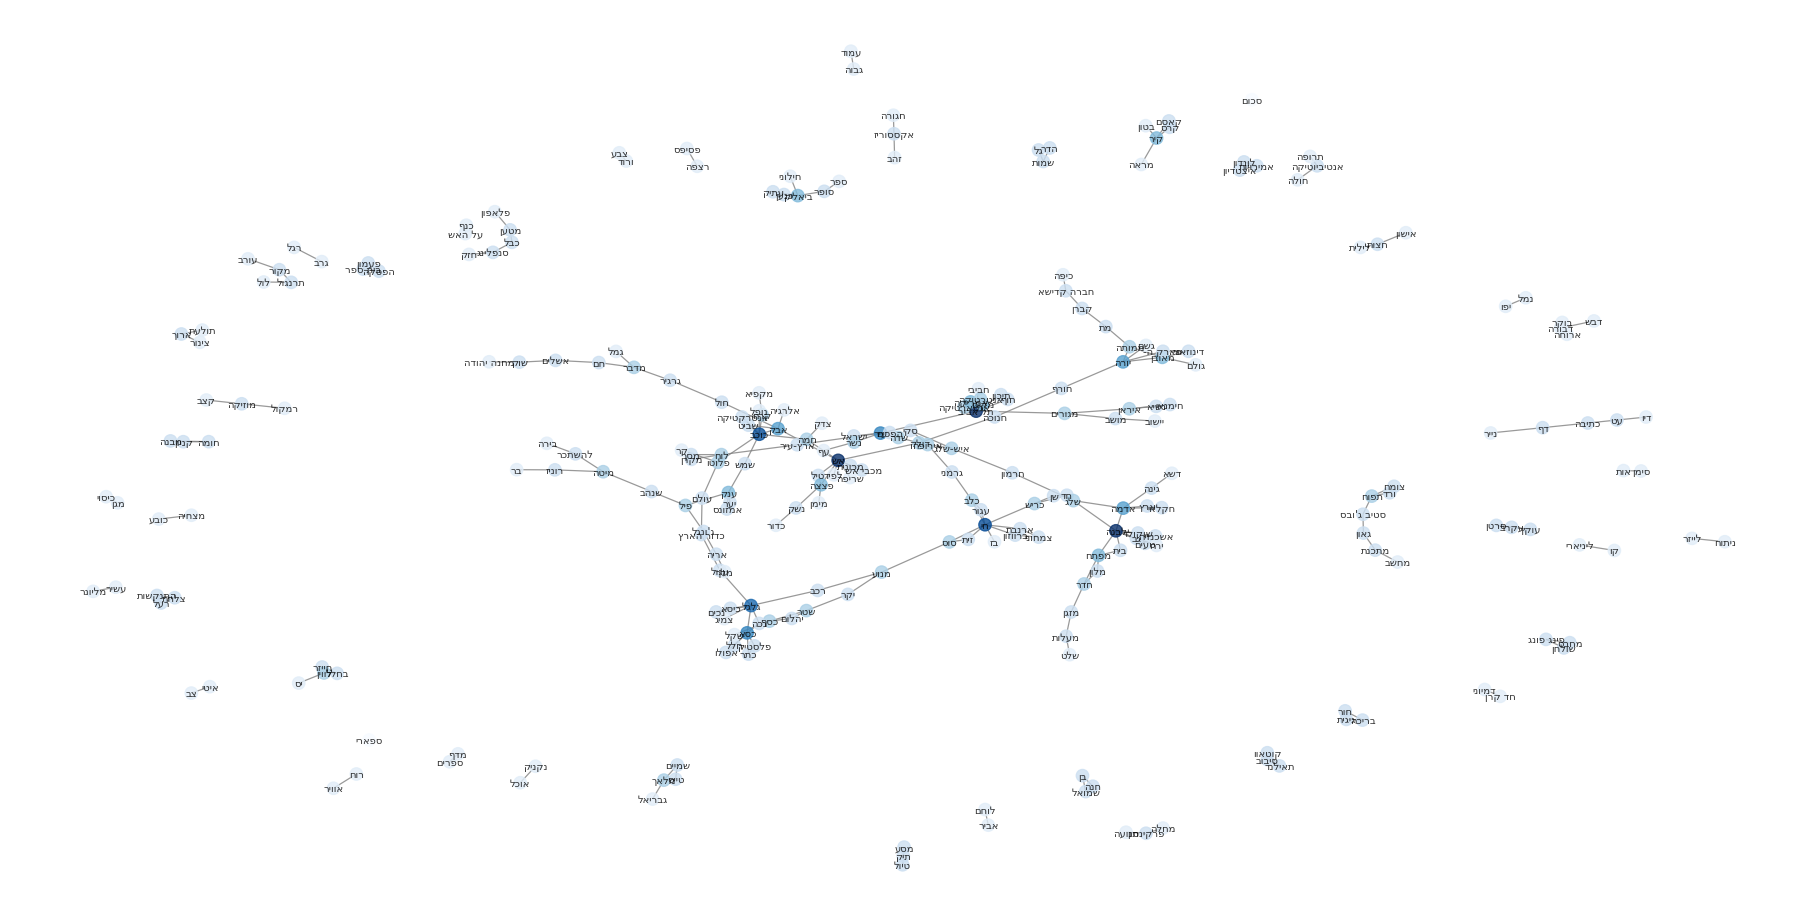

In [0]:
options = {
  'with_labels': True,
  'node_color': degrees,
  'cmap': plt.cm.Blues,
  'node_size': 100,
  'edge_color': 'grey',
  'width': 1,
  'font_size': 8,
  'font_color': 'black',
  'style': 'solid',
  'node_shape': 'o',
  'alpha': 0.8
}

nx.draw(G, **options)

### Circular Graph

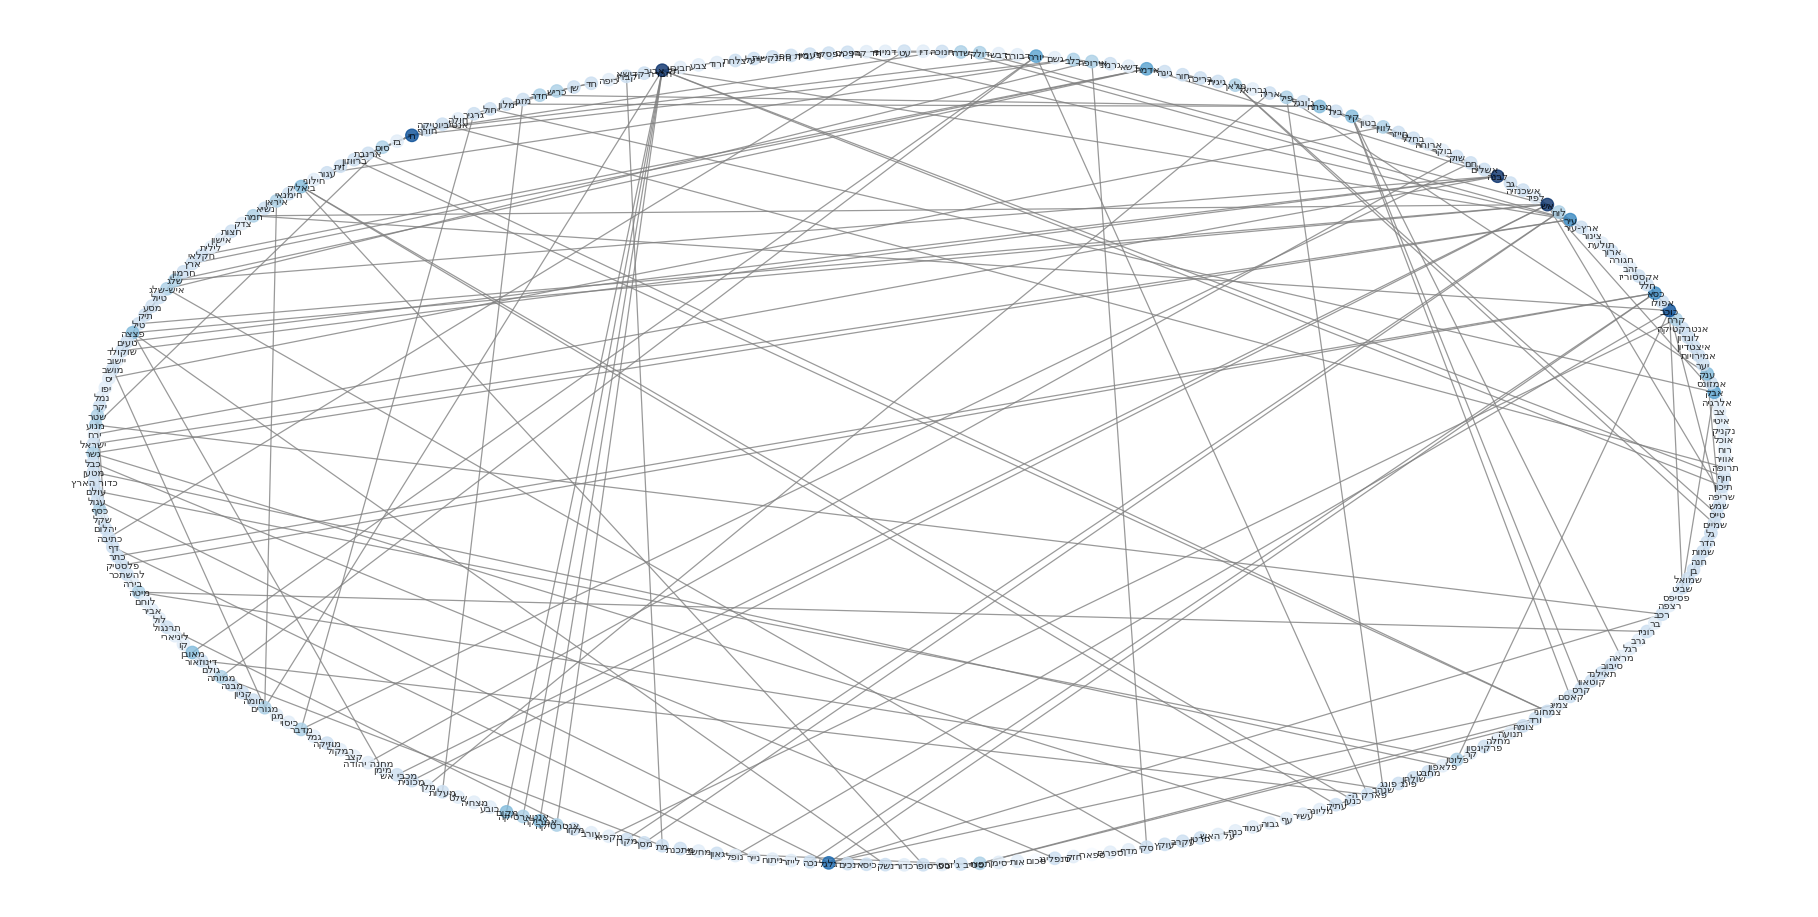

In [0]:
options = {
  'with_labels': True,
  'node_color': degrees,
  'cmap': plt.cm.Blues,
  'node_size': 100,
  'edge_color': 'grey',
  'width': 1,
  'font_size': 8,
  'font_color': 'black',
  'style': 'solid',
  'node_shape': 'o',
  'alpha': 0.8
}
nx.draw_circular(G, **options)

### Kamada-Kawai Graph

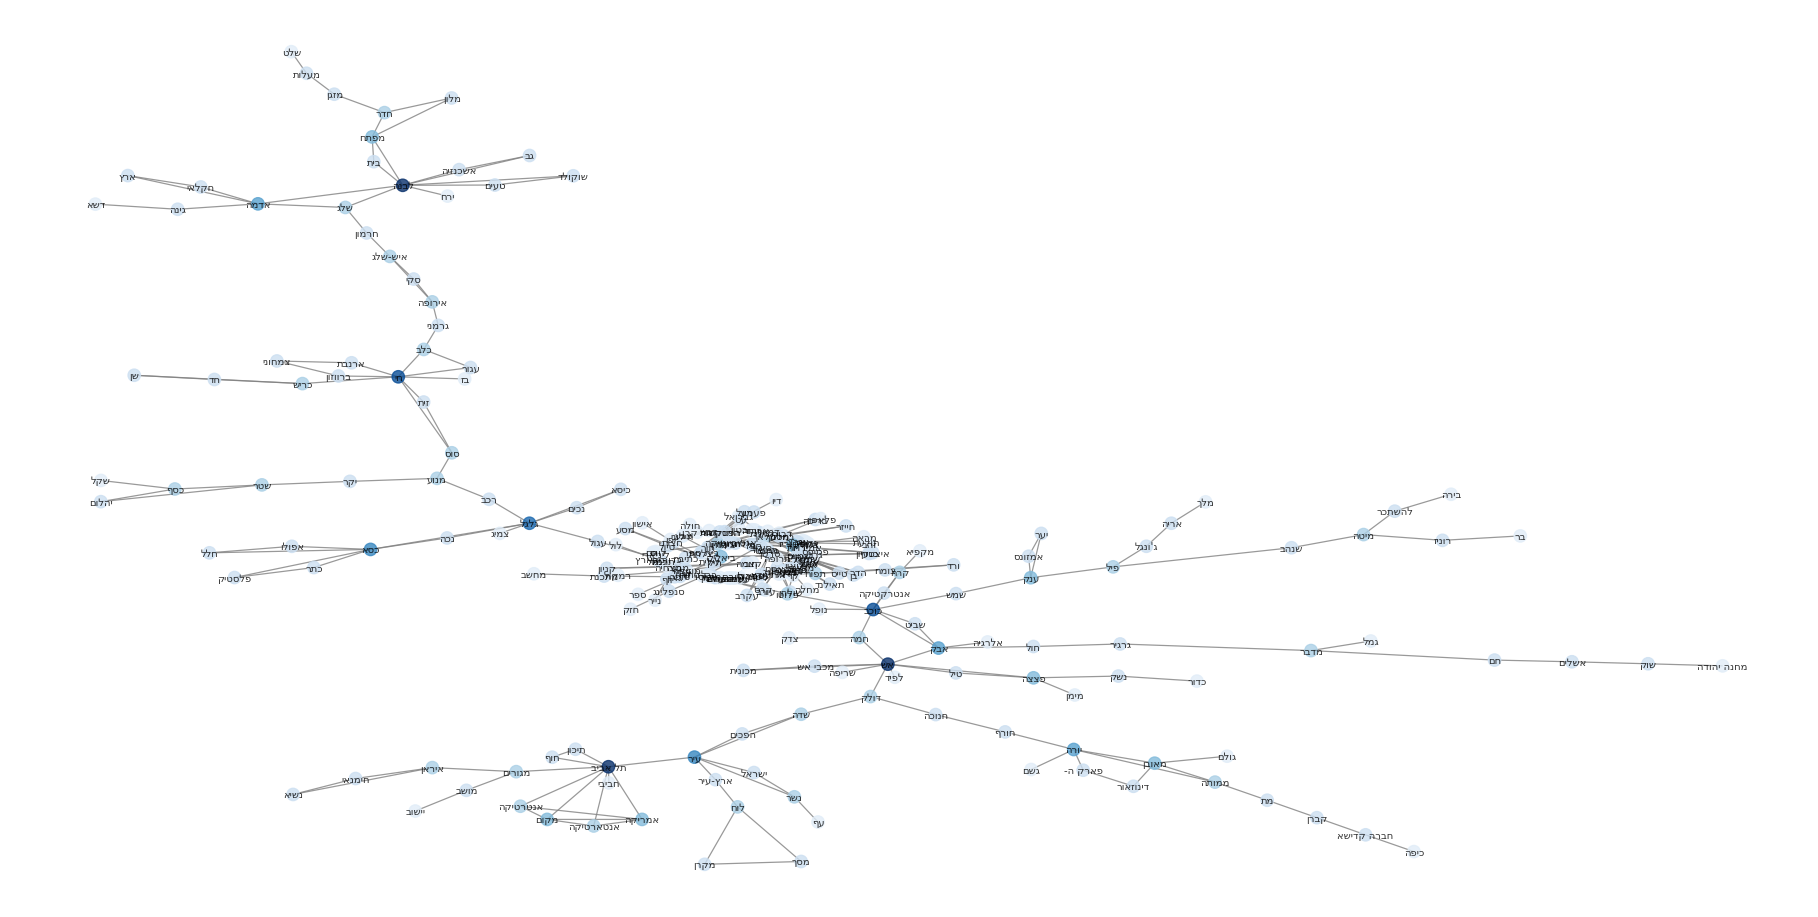

In [0]:
options = {
  'with_labels': True,
  'node_color': degrees,
  'cmap': plt.cm.Blues,
  'node_size': 100,
  'edge_color': 'grey',
  'width': 1,
  'font_size': 8,
  'font_color': 'black',
  'style': 'solid',
  'node_shape': 'o',
  'alpha': 0.8
}
nx.draw_kamada_kawai(G, **options)

### Spring Graph

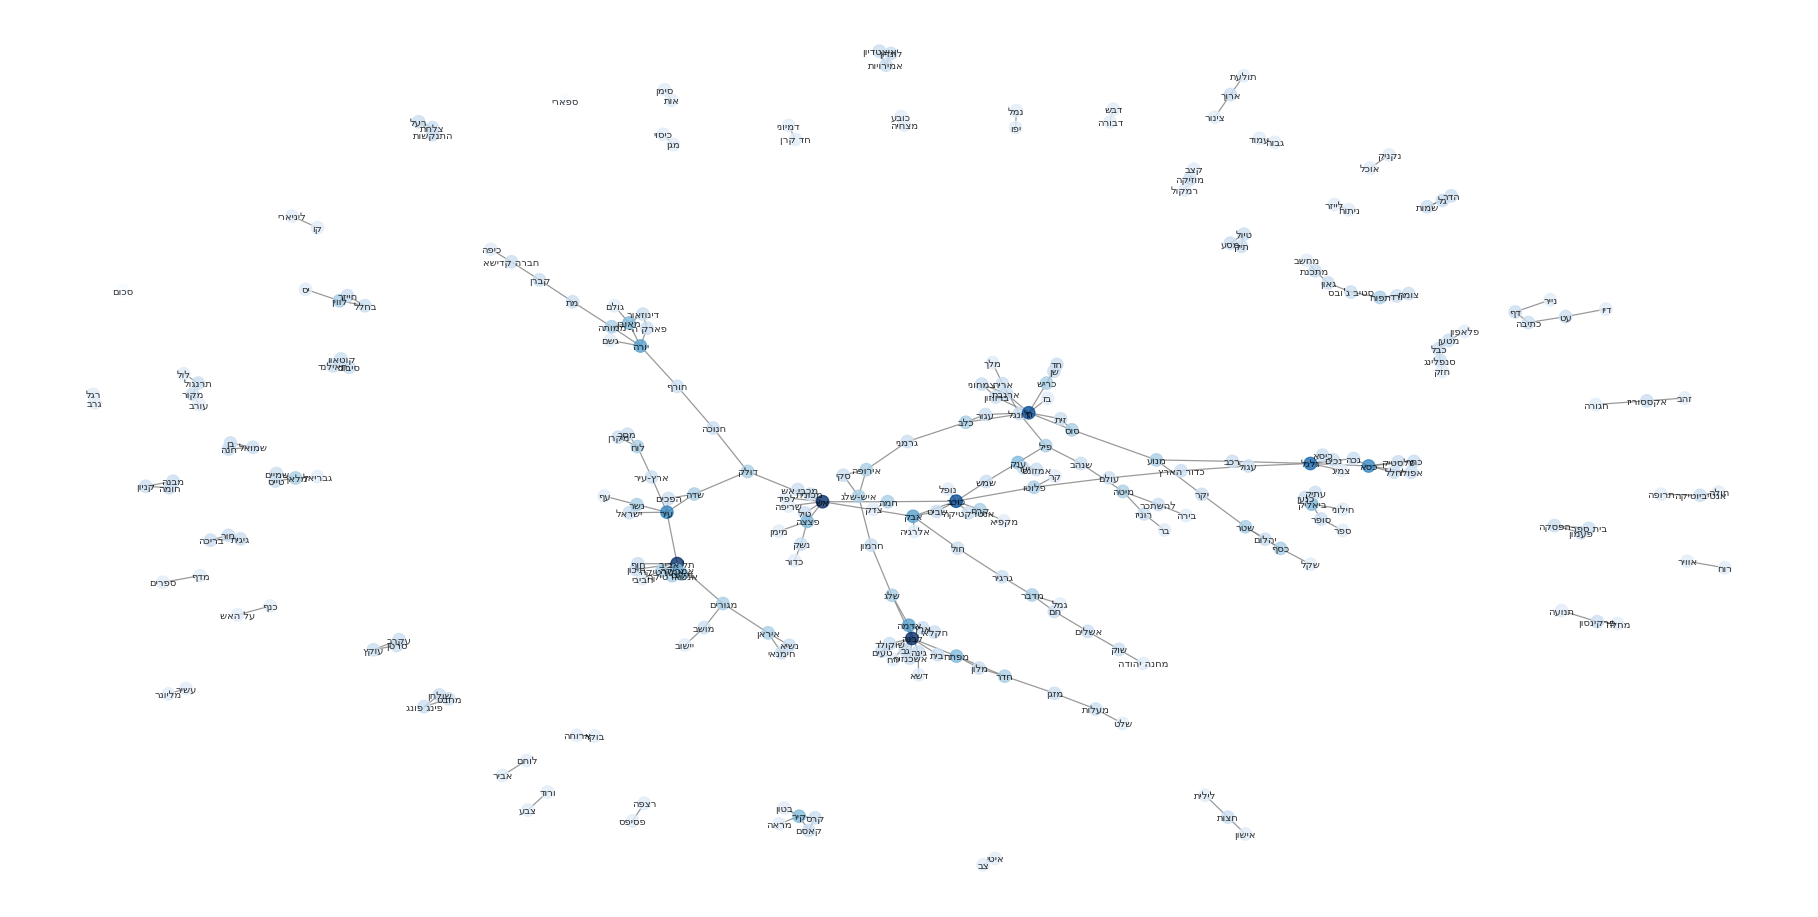

In [0]:
options = {
  'with_labels': True,
  'node_color': degrees,
  'cmap': plt.cm.Blues,
  'node_size': 100,
  'edge_color': 'grey',
  'width': 1,
  'font_size': 8,
  'font_color': 'black',
  'style': 'solid',
  'node_shape': 'o',
  'alpha': 0.8,
  'edge_labels': labels
}

nx.draw_spring(G, **options)

### "Spring Garph": edge color by weight (white to black)

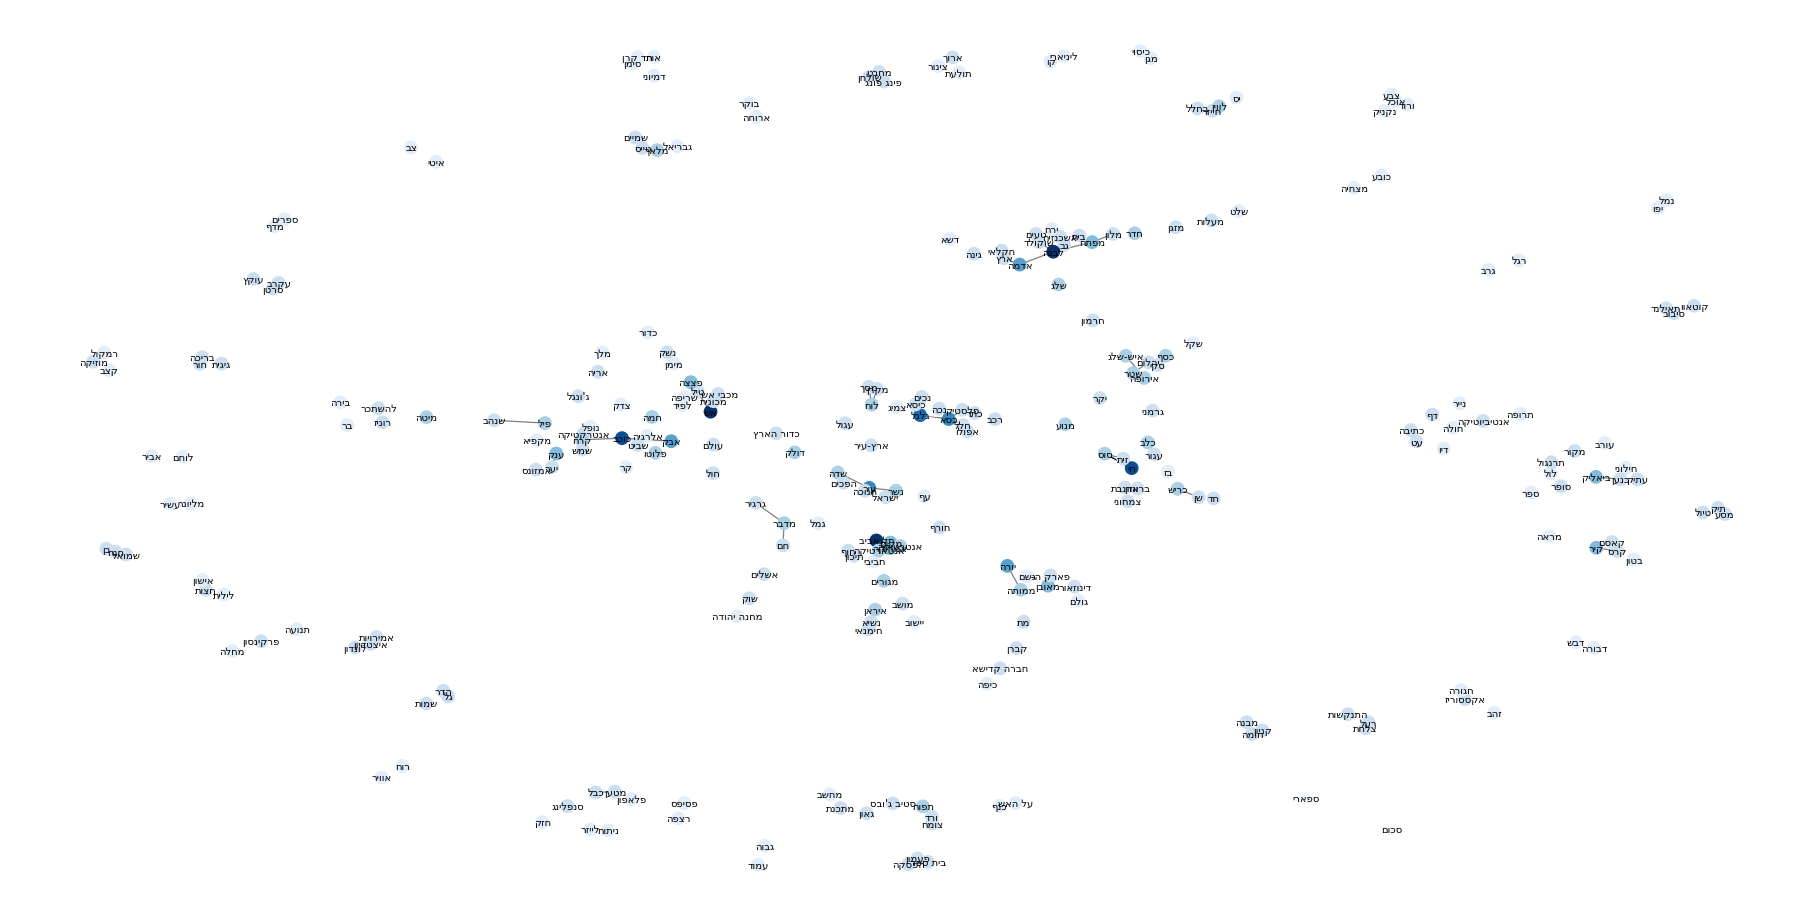

In [0]:
pos = nx.spring_layout(G)

options = {
  'with_labels': True,
  'node_color': degrees,
  'cmap': plt.cm.Blues,
  'node_size': 100,
  'edge_color': weights,
  'edge_cmap': plt.cm.binary,
  'width': 1,
  'font_size': 8,
  'font_color': 'black',
  'style': 'solid',
  'node_shape': 'o',
  'alpha': 1
}

nx.draw(G,pos, **options)

### "Spring Garph":  print weight in each edge.

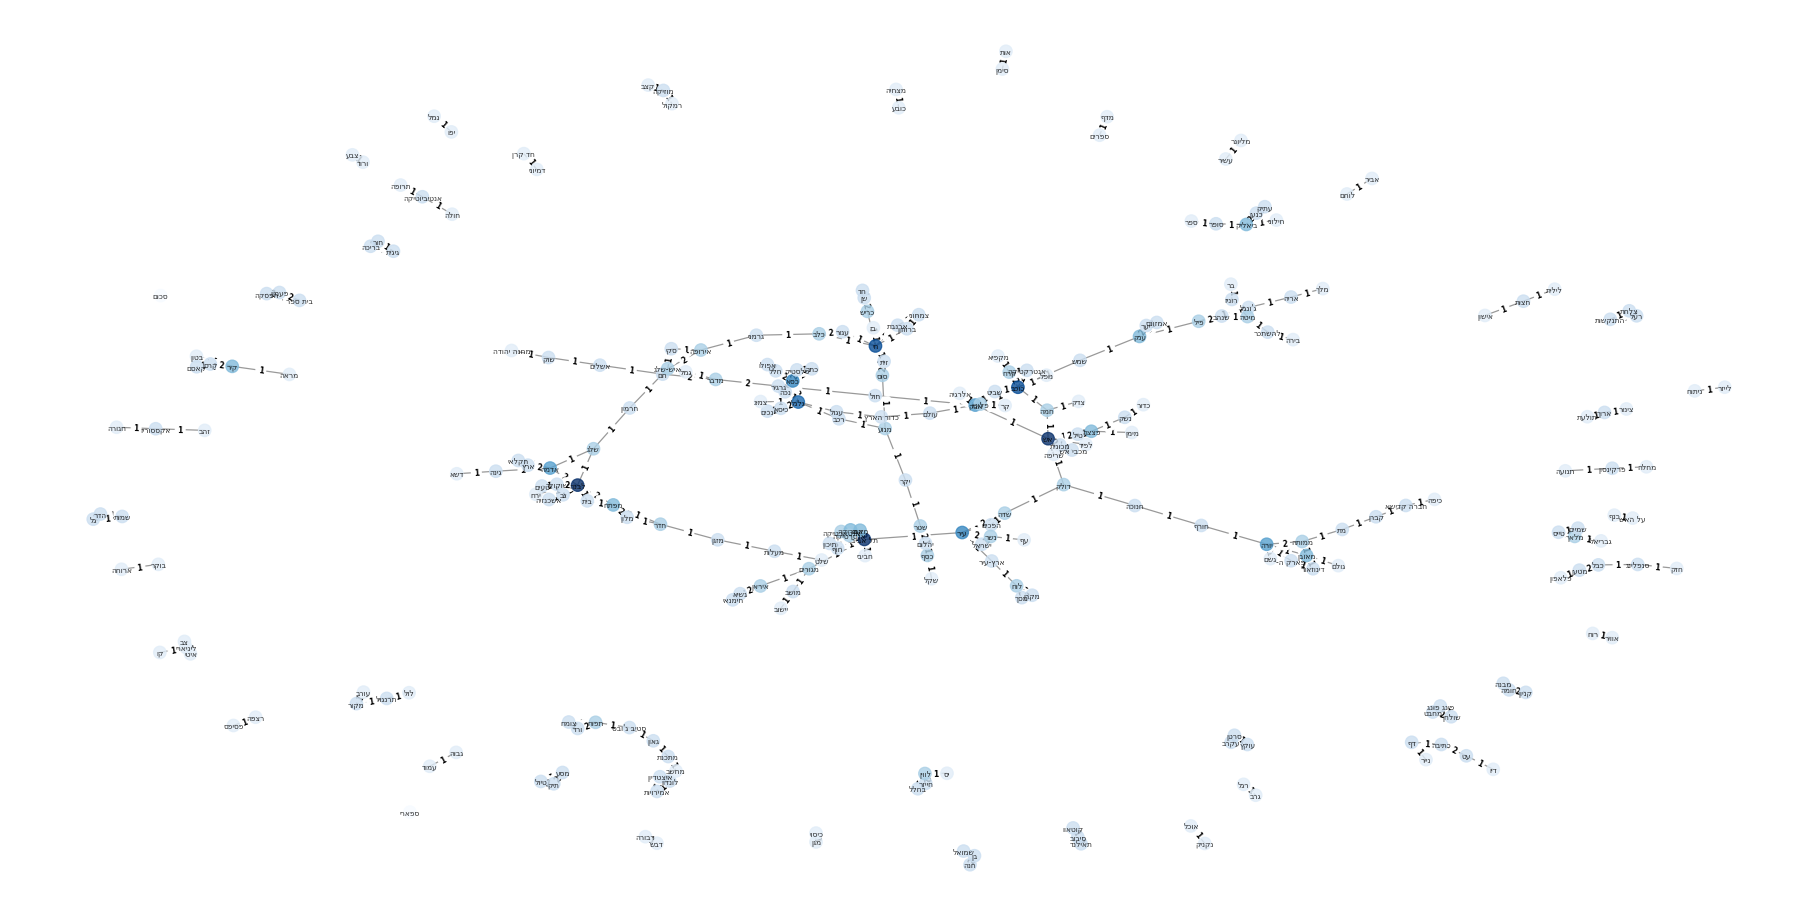

In [0]:
labels = nx.get_edge_attributes(G,'weight')
pos = nx.spring_layout(G)

options = {
  'with_labels': True,
  'node_color': degrees,
  'cmap': plt.cm.Blues,
  'node_size': 100,
  'edge_color': 'grey',
  'width': 1,
  'font_size': 6,
  'font_color': 'black',
  'style': 'solid',
  'node_shape': 'o',
  'alpha': 0.8,
}

edge_weight_options = {
   'edge_labels': labels,
    'font_size': 6,
    'font_weight': 'bold',
    
}

nx.draw(G,pos,**options)
nx.draw_networkx_edge_labels(G,pos,**edge_weight_options);

_______________________________________________________